Попробуем собрать какой-никакой генератор текстов

# FIXED
- модельки работают, чето генерят


In [1]:
import pickle
import json
import re
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F

import youtokentome as yttm

from IPython.display import clear_output
from prettytable import PrettyTable
from random import sample

# загрузить готовые модели, не обновлять ничего, кроме тестовых прогонов
QUICK_RUN = True

Загрузка и подготовка данных
- ведущий пробел, чтобы RNN узнавала начало последовательности с пробела как начало любой последовательности
- ведущий пробел - очень плохая идея, но это стало понятно толко потом

In [2]:
NAMES_DUMP = "./datasets/russian_names.txt"
QUOTES_DUMP = "./datasets/author_quotes.txt"
LYRICS_DUMP = "./datasets/vysotskiy_all.json"

with open(NAMES_DUMP) as f:
    names = f.read().split("\n")
    names = [" " + n for n in names]    # чтобы принимало пустой (пробельный) сид

with open(QUOTES_DUMP) as f:
    quotes = f.read().split("\n")
    quotes = [" " + q for q in quotes]  # чтобы принимало пустой (пробельный) сид

with open(LYRICS_DUMP) as f:
    lyrics_json = json.load(f)

names[0]

' Ababko'

In [3]:
print(np.mean(list(map(len, quotes))))
quotes[0]

131.53450754852625


' If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [4]:
df = pd.DataFrame.from_dict(lyrics_json).T
df["len"] = df["lyrics"].apply(lambda x: len(x))

drop_above = 2000
df = df[df["len"] < drop_above]

MAX_LEN = df["len"].max()
MEAN_LEN = df["len"].mean()
STD_LEN = df["len"].std()

df["text"] = " " + df["name"] + "\n\n\n\n" + df["lyrics"]   # а вдруг начнет узнавать названия?
lyrics = df["text"].to_list()
lyrics[0]

' А люди всё роптали и роптали...\n\n\n\nА люди всё роптали и роптали,\nА люди справедливости хотят:\n"Мы в очереди первыми стояли,\nА те, кто сзади нас, уже едят!"\n\nИм объяснили, чтобы не ругаться:\n"Мы просим вас, уйдите, дорогие!\nТе, кто едят, — ведь это иностранцы,\nА вы, прошу прощенья, кто такие?"\n\nА люди всё кричали и кричали,\nА люди справедливости хотят:\n"Ну как же так?! Мы в очереди первыми стояли,\nА те, кто сзади нас, уже едят!"\n\nНо снова объяснил администратор:\n"Я вас прошу, уйдите, дорогие!\nТе, кто едят, — ведь это ж делегаты,\nА вы, прошу прощенья, кто такие?"\n\nА люди всё кричали и кричали —\nНаверно, справедливости хотят:\n"Ну как же так?! Ведь мы ещё...\nНу как же так?! Ну ещё...\nВедь мы в очереди первыми стояли,\nА те, кто сзади нас, уже едят!"'

In [5]:
df["len"].describe()

count     706.000000
mean      845.920680
std       501.474469
min        45.000000
25%       444.250000
50%       821.500000
75%      1212.750000
max      1982.000000
Name: len, dtype: float64

# Вспомогательные полезности

In [6]:
# функция для оценки параметров модели
def count_parameters(model):
    table = PrettyTable(["Modules/Tensors", "GPU", "Dims", "Parameters", "Type", "Memory"])
    total_params, total_mem = 0, 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        dims =  " x ".join(map(str,  parameter.size()))
        cuda = "+" if parameter.is_cuda else " "
        t = parameter.dtype
        mem = parameter.dtype.__sizeof__() * params
        table.add_row([name, cuda, dims, params, t, mem])
        total_params += params
        total_mem += mem
    print(table)
    print(f"Total Trainable Params: {total_params}\nTotal memory: {total_mem/1024/1024:.2f} Mb")
    return total_params

In [7]:
def dump_tensors():
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	table = PrettyTable(["Kind", "GPU", "Dims", "Parameters", "Type", "Memory"])
	count, total_params, total_gpu_mem, total_cpu_mem = 0, 0, 0, 0

	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):
				kind = type(obj).__name__
				cuda = "+" if obj.is_cuda else " "
				dims =  " x ".join(map(str,  obj.size()))
				params = obj.numel()
				t = obj.dtype
				mem = obj.dtype.__sizeof__() * params
				# print([kind, cuda, dims, params, t, mem])
				table.add_row([kind, cuda, dims, params, t, mem])
				count += 1
				total_params += params
				total_gpu_mem += mem if obj.is_cuda else 0
				total_cpu_mem += mem if not obj.is_cuda else 0
		except Exception:
			pass 
	print(table)
	print(f"Total {count} objects with {total_params} params")
	print(f"Total GPU / CPU memory: {total_gpu_mem/1024/1024:.2f} / {total_cpu_mem/1024/1024:.2f} Mb")

dump_tensors()

+------+-----+------+------------+------+--------+
| Kind | GPU | Dims | Parameters | Type | Memory |
+------+-----+------+------------+------+--------+
+------+-----+------+------------+------+--------+
Total 0 objects with 0 params
Total GPU / CPU memory: 0.00 / 0.00 Mb


/home/user1/envs/py39/lib/python3.9/site-packages/torch/distributed/distributed_c10d.py:170: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


# Соберем все наброски в классы

**Тривиальный энкодер**
- составляет словарь по текстовому корпусу
- кодирует текст в цифровое представление (НЕ эмбеддинги)
- декодирует прогноз нейросети в текст

In [8]:
class CharEncoder():
    """Простейший энкодер, каждый символ в корпусе - это токен"""
    def __init__(self, texts_corpus, pad="<pad>"):
        self.PAD = pad  # символ-заполнитель для 0 значения векторного представления
        self.tokens = [self.PAD] + list(set(''.join(texts_corpus))) 
        self.token_to_id = {token: idx for idx, token in enumerate(self.tokens)}
        self.token_to_id[self.PAD] = 0   
        self.dict_size = len(self.tokens)                       # max input <= (embedding_dim - 1)

    def encode(self, texts, dtype='int32', batch_first = True):
        max_batch_len = max(map(len, texts))
        data_ix = np.zeros([len(texts), max_batch_len], dtype)

        for i in range(len(texts)):
            line_ix = [self.token_to_id[c] for c in texts[i]]
            data_ix[i, :len(line_ix)] = line_ix
        
        if not batch_first:                                     # [batch, token] -> [token, batch] (не используется)
            data_ix = np.transpose(data_ix)

        return data_ix

    def decode(self, vector):
        raw = ''.join([self.tokens[ix] for ix in vector])
        p = re.compile(f"({self.PAD})+") 
        res = p.sub(" ", raw)
        return res

Тест энкодера

In [9]:
e = CharEncoder(names)
assert all([e.token_to_id[e.tokens[i]] == i for i in range(e.dict_size - 1)])

e.decode(e.encode(names[:2])[0])    # ровно 1 последовательность
e.encode(names[:2])                 # произвольный батч -> batch X max_batch_len
e.tokens, e.token_to_id
e.dict_size

52

**Byte-pair encoder**

Попробованы:
- пакет bpe (сырое нерабочее)
- tokenizer (не осилил)
- youtokentome

Пакет bpe (чей-то учебный проект)
  - невнятное описание, не умеет без lowercase, делит по " " и это захардкодено, не понимает ведущего пробела, проглатывает переносы строки
  - костыление приводит к UB, которое муторно отлавливать
  - в общем, как набудь потом

In [10]:
class BPEncoder():
    def __init__(self, train_file, model_file, dict_size=1000):
        """YouTokenToMe - работает только через внешний файл"""
        self.train_file = train_file
        self.model_file = model_file
        self.dict_size = dict_size
        yttm.BPE.train(data=self.train_file, vocab_size=self.dict_size, model=self.model_file)
        self.tokenizer = yttm.BPE(self.model_file)
    
    def encode(self, texts, dtype='int32', batch_first = True):
        vectors = self.tokenizer.encode(texts)

        max_batch_len = max(map(len, vectors))
        data_ix = np.zeros([len(texts), max_batch_len], dtype)
        
        for i in range(len(texts)):
            data_ix[i, :len(vectors[i])] = vectors[i]
        
        if not batch_first:                                     # [batch, token] -> [token, batch] (не используется)
            data_ix = np.transpose(data_ix)

        return data_ix

    def decode(self, vector):
        """Одна или более последовательностей -> в одну строку"""
        vector = vector.tolist()
        decoded = self.tokenizer.decode(vector)
        decoded = " ".join(decoded)
        decoded = decoded.replace(f"{self.tokenizer.vocab()[0]}", "")
        return decoded

train_file = "./datasets/russian_names.txt"
model_file = "./datasets/russian_names.txt.yttm"
bpe = BPEncoder(train_file, model_file, dict_size=300)

bpe.encode(names[5:12])                     # произвольный батч -> batch X max_len
bpe.dict_size, len(bpe.tokenizer.vocab()), bpe.tokenizer.vocab()
bpe.decode(bpe.encode(names[5:12]))
bpe.decode(bpe.encode(['Iva']))         
bpe.decode(bpe.encode(names[:2]))           # 1 или более последовательностей -> в одну строку

Training parameters
  input: ./datasets/russian_names.txt
  model: ./datasets/russian_names.txt.yttm
  vocab_size: 300
  n_threads: 4
  character_coverage: 1
  pad: 0
  unk: 1
  bos: 2
  eos: 3

reading file...
learning bpe...
number of unique characters in the training data: 50
number of deleted characters: 0
number of unique characters left: 50
model saved to: ./datasets/russian_names.txt.yttm


'Ababko Abaev'

RNN class

In [11]:
class CharRNNLoop(nn.Module):
    def __init__(self, dict_size, emb_size=16, rnn_num_units=64, num_layers=1):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(dict_size, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, dict_size)
        
    def forward(self, x):
        embeddings = self.emb(x)
        h_seq, _ = self.rnn(embeddings)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

GRU class

In [12]:
class CharGRULoop(nn.Module):
    def __init__(self, dict_size, emb_size=16, rnn_num_units=64, num_layers=1):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(dict_size, emb_size)
        self.gru = nn.GRU(emb_size, rnn_num_units, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, dict_size)
        
    def forward(self, x):
        embeddings = self.emb(x)
        h_seq, _ = self.gru(embeddings)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

LSTM class

In [13]:
class CharLSTMLoop(nn.Module):
    def __init__(self, dict_size, emb_size=16, rnn_num_units=64, num_layers=1):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(dict_size, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, dict_size)
        
    def forward(self, x):
        embeddings = self.emb(x)
        h_seq, _ = self.lstm(embeddings)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

Тест: энкодер + рекуррентная НС

In [14]:
def test(model, enc=e):
    model = model(enc.dict_size, emb_size=8, rnn_num_units=16, num_layers=2)
    batch_ix = enc.encode(sample(names, 4))
    batch_ix = torch.LongTensor(batch_ix)
    logp_seq = model.forward(batch_ix)
    loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, enc.dict_size), 
                      batch_ix[:, 1:].contiguous().view(-1))
    loss.backward()
                                    # CharEncoder(names):
    print(f"{batch_ix.shape=}")     # [8, 21] = [batch, max_len]
    print(f"{logp_seq.shape=}")     # [8, 21, 52] = [batch, max_len, dict_size]
    print(f"{loss=}\n")             # scalar

test(CharRNNLoop)
test(CharLSTMLoop)
test(CharGRULoop)

gc.collect()                        # память GPU свободна

batch_ix.shape=torch.Size([4, 11])
logp_seq.shape=torch.Size([4, 11, 52])
loss=tensor(4.0003, grad_fn=<NllLossBackward0>)

batch_ix.shape=torch.Size([4, 10])
logp_seq.shape=torch.Size([4, 10, 52])
loss=tensor(3.9978, grad_fn=<NllLossBackward0>)

batch_ix.shape=torch.Size([4, 13])
logp_seq.shape=torch.Size([4, 13, 52])
loss=tensor(3.9341, grad_fn=<NllLossBackward0>)



0

Генератор текста

In [15]:
class TextGenerator():
    def __init__(self, name_prefix, encoder, device=None, model=CharRNNLoop, **model_params):
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = torch.device(device)
        
        self.history = []        
        self.encoder = encoder
        self.dict_size = encoder.dict_size
        self.model = model(self.dict_size, **model_params)
        self.model.to(self.device)
        self.name_prefix = f"{name_prefix}-{self.model._get_name()}"

    def train(self, texts, steps=1000, batch_size=32, 
                          optimizer=None, lr=0.001,
                          draw=True, draw_step=100, draw_win=None,
                          check_convergence=False):
        
        if optimizer is None:
            optimizer = torch.optim.Adam(self.model.parameters(), lr=lr) 
        self.model.train()  # перевести в режим обучения

        for i in range(steps):
            batch_ix = self.encoder.encode(sample(texts, batch_size))
            batch_ix = torch.LongTensor(batch_ix).to(self.device)
            
            logp_seq = self.model.forward(batch_ix)                                     # batch_size X max_batch_len X dict_size

            # compute loss
            predictions_logp = logp_seq[:, :-1].contiguous().view(-1, self.dict_size)   # предсказанные логиты вероятностей следующих токенов (кроме последней)
            actual_next_tokens = batch_ix[:, 1:].contiguous().view(-1)                  # фактические следующие токены (целевые) (кроме первого)
            loss = F.nll_loss(input=predictions_logp, target=actual_next_tokens)        # среднее по логитам целевых токенов
            # loss = -torch.mean(torch.gather(predictions_logp, dim=1, index=actual_next_tokens[:, None]))
            
            # train with backprop
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            self.history.append(loss.detach().cpu().tolist())
            if draw and (i + 1) % draw_step == 0:
                clear_output(True)
                start = max(0, len(self.history) - draw_win) if draw_win else 0
                x_labels = list(range(start, len(self.history)))
                plt.plot(x_labels, self.history[start:], label='loss')
                plt.legend()
                plt.show()

        if check_convergence:
            assert np.mean(self.history[:steps//4]) > np.mean(self.history[-(steps//4):]), "RNN didn't converge."
    
    def generate(self, seed_phrase=" ", length=100, temperature=1.0):
        self.model.eval()   # перевести в режим прогноза
        
        x_sequence = self.encoder.encode([seed_phrase])[:, :len(seed_phrase)]   # [[x1, ..., xn, 0, ..., 0]] -> [[x1, ..., xn]]
        x_sequence = torch.LongTensor(x_sequence).to(self.device)               # 1 X seed_len

        #start generating
        for _ in range(length - len(seed_phrase)):
            logp_next = self.model.forward(x_sequence).detach().cpu()

            p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0, -1]
            next_ix = np.random.choice(self.dict_size, p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(self.device)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1).to(self.device)
            
        x_sequence = x_sequence.data.detach().cpu().numpy()[0]
        
        return self.encoder.decode(x_sequence)

    def save(self, yttm=False):
        if not yttm:
            with open(f"./models/{self.name_prefix}-encoder.pkl", "wb") as f:
                pickle.dump(self.encoder, f)
        np.save(f"./models/{self.name_prefix}-history.npy", self.history)
        torch.save(self.model.state_dict(), f"./models/{self.name_prefix}-model.pth")
    
    def load(self, yttm=False):
        try:
            if not yttm:
                with open(f"./models/{self.name_prefix}-encoder.pkl", "rb") as f:
                    self.encoder = pickle.load(f)
            self.dict_size = self.encoder.dict_size
            
            self.history = np.load(f"./models/{self.name_prefix}-history.npy")
            self.model.load_state_dict(torch.load(f"./models/{self.name_prefix}-model.pth", 
                                            map_location=self.device))
        except:
            raise ValueError("Model NOT loaded. Either no dumps or model parameters of dumps mismatch.")

**Че такое эмбеддинг?**

In [16]:
dict_size, emb_size = 2, 3

# матрица весов эмбеддингов, если не грузится готовая (например pretrained для некоторых токенов),
# то прост инициализируется стандартным нормальным шумом
emb = nn.Embedding(dict_size, emb_size)     

x1 = [1,0,0]  # текст 1
x2 = [0,1,0]  # текст 2

x = torch.tensor([x1, x2])  # пакет текстов (батч)

emb(x), emb.weight[x1]      # это прост выборка по индексам текстов из матрицы весов

(tensor([[[ 0.7960, -1.4435,  1.1900],
          [ 0.0561, -0.4360, -1.5682],
          [ 0.0561, -0.4360, -1.5682]],
 
         [[ 0.0561, -0.4360, -1.5682],
          [ 0.7960, -1.4435,  1.1900],
          [ 0.0561, -0.4360, -1.5682]]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.7960, -1.4435,  1.1900],
         [ 0.0561, -0.4360, -1.5682],
         [ 0.0561, -0.4360, -1.5682]], grad_fn=<IndexBackward0>))

## Потестим на именах

- Создание
- Обучение
- Сохранение
- Генерация

Параметр `rnn_num_units` - количество скрытых слоев в сети в случае RNN означает глубину памяти, насколько длинные входные последовательности будут обрабатываться НС как единое целое, т.е. это максимальная длина последовательности для которых НС будет подбирать связи.

Параметр `emb_size` - размерность векторного представления токенов (обучаемое (но не в данном случае) векторное представление объекта), характеризует количество степеней свободы, в которых может быть оценено сходство текстов

Параметр `num_layers` - количество слоев НС, характеризует степень обобщения входных данных, сложность отыскиваемых закономерностей (степень кривизны разделяющей классы поверхности)

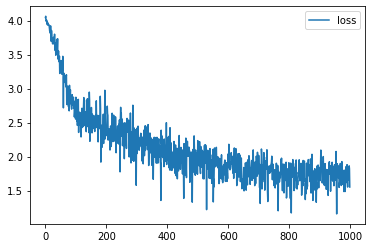

Ivatyon  Ivanov  Ivaziiif  Ivanmochov  Ivahompov  Ivankolov  Iva  Ivakon  Ivah  Ivanky 


In [17]:
names_encoder = CharEncoder(names)

names_generator = TextGenerator(name_prefix="names",
                                      encoder=names_encoder, 
                                      model=CharRNNLoop, 
                                      emb_size=8, rnn_num_units=16, num_layers=1)

names_generator.train(names, steps=1000)
names_generator.save()

print(*[names_generator.generate(seed_phrase="Iva", length=20) for _ in range(10)])

- загрузка
- генерация

In [18]:
names_generator1 = TextGenerator(name_prefix="names", 
                                encoder=names_encoder,
                                model=CharRNNLoop, 
                                emb_size=8, rnn_num_units=16, num_layers=1) # для загрузки эти параметры должны совпадать
names_generator1.load()
print(*[names_generator1.generate(length=20) for _ in range(10)])

 Vatelion i   Vinrov   Stien u   TupovovD on   Ananov   Areftte o  Borwan ss   Chadezya   Veroven   B,eruna 


- доучивание
- сохранение
- генерация

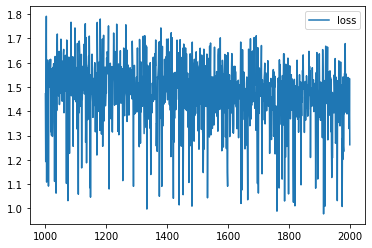

 Ebeomyav   Yadilov   Janonkov   Vuhonfs   Myamenshav   Maloryev   Jakhanu   Kamimugashov   ashulniiy   Jomag 


In [19]:
names_generator.train(names, batch_size=128, steps=1000, lr=0.001 * 0.5,
                             draw_step= 50, draw_win=1000)
names_generator.save()

print(*[names_generator.generate(length=20) for _ in range(10)])

In [20]:
del names_encoder, names_generator, names_generator1
gc.collect()
torch.cuda.empty_cache()    # память GPU свободна

BPE

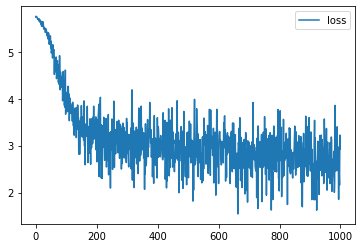

Ivaukovgkin Ivadinov Ivao Ivairoffl Ivaovskyovskyas Ivaoranuhimov Iva Ivaushinoko Ivaonohovskyk Ivaor


In [21]:
train_file = "./datasets/russian_names.txt"
model_file = "./datasets/russian_names.txt.yttm"
bpe_names_encoder = BPEncoder(train_file, model_file, dict_size=300)

bpe_names_generator = TextGenerator(name_prefix="names-bpe",
                                      encoder=bpe_names_encoder, 
                                      model=CharRNNLoop, 
                                      emb_size=8, rnn_num_units=16, num_layers=1)

bpe_names_generator.train(names, steps=1000)
bpe_names_generator.save(yttm=True)

bpe_names_generator1 = TextGenerator(name_prefix="names-bpe", 
                                encoder=bpe_names_encoder,
                                model=CharRNNLoop, 
                                emb_size=8, rnn_num_units=16, num_layers=1) # для загрузки эти параметры должны совпадать
bpe_names_generator1.load(yttm=True)

print(*[bpe_names_generator1.generate(seed_phrase="Iva", length=20) for _ in range(10)])

del bpe_names_encoder, bpe_names_generator, bpe_names_generator1
gc.collect()
torch.cuda.empty_cache()    # память GPU свободна

# Генерация лозунгов

#### Цитаты RNN

- 3 мин. 20 сек.

In [22]:
SKIP = QUICK_RUN

quotes_encoder = CharEncoder(quotes)
quotes_generator = TextGenerator(name_prefix="quotes",
                                 encoder=quotes_encoder, 
                                 model=CharRNNLoop, 
                                 emb_size=16, rnn_num_units=128, num_layers=2)

count_parameters(quotes_generator.model)

+----------------------+-----+-----------+------------+---------------+---------+
|   Modules/Tensors    | GPU |    Dims   | Parameters |      Type     |  Memory |
+----------------------+-----+-----------+------------+---------------+---------+
|      emb.weight      |  +  |  86 x 16  |    1376    | torch.float32 |  121088 |
|   rnn.weight_ih_l0   |  +  |  128 x 16 |    2048    | torch.float32 |  180224 |
|   rnn.weight_hh_l0   |  +  | 128 x 128 |   16384    | torch.float32 | 1441792 |
|    rnn.bias_ih_l0    |  +  |    128    |    128     | torch.float32 |  11264  |
|    rnn.bias_hh_l0    |  +  |    128    |    128     | torch.float32 |  11264  |
|   rnn.weight_ih_l1   |  +  | 128 x 128 |   16384    | torch.float32 | 1441792 |
|   rnn.weight_hh_l1   |  +  | 128 x 128 |   16384    | torch.float32 | 1441792 |
|    rnn.bias_ih_l1    |  +  |    128    |    128     | torch.float32 |  11264  |
|    rnn.bias_hh_l1    |  +  |    128    |    128     | torch.float32 |  11264  |
| hid_to_logits.

64182

In [23]:
if SKIP:
    quotes_generator.load()
else:
    quotes_generator.train(quotes, steps=1000)
    quotes_generator.save()

Доучивание
- увеличим размер пакета + уменьшим шаг -> увеличим точность градиентного шага -> уменьшим дисперсию ошибки функции потерь

In [24]:
if not SKIP:
    quotes_generator.train(quotes, batch_size=128, steps=1000, lr = 0.001 * 0.2, 
                                   draw_step=50, draw_win=1000)
    quotes_generator.save()

Результат

In [25]:
for _ in range(10):
    length = round(np.random.randn() * np.sqrt(100) + 150)
    print('-> ', quotes_generator.generate(length=length))

->   And alst who sare psomething place or the been not maron. 
->   Meliends, I have that. What beligate mestrying of story. There ow mistanding. 
->   There I fan pail wishes, Hlander its, usway, and Ammone that's live world are 'Ding man with the think the receste than ozsting cotalucative than im wants o
->   Dich in scopdess acpriges; I Coursule. Neging firs, things on was the griters to burets qursliticl, ant. 
->   The ullise our but for the am, the of read. It's not more a because houth But world goseonters of as sing oun't alone who are in you hone a lu
->   You netde undiess ippresels hise grangs iutver alward to lichtent in to brrone oy. There or about, and everybods where as be. 
->   It's mary to standing betoring to make this. 
->   Sto the mover, batbor and tum beader world, I dan Littly the trajkt soriin, Te one lo:e. 
->   I appon, bestand of charking it cazled in Roliction from. 
->   Playres and a verict alwer has lust find creatirity hissert, at. Un eded so take tho

#### Цитаты на GRU

- 4 мин.

In [26]:
del quotes_generator
gc.collect()
torch.cuda.empty_cache()    # память GPU свободна

In [27]:
SKIP = QUICK_RUN

quotes_generator = TextGenerator(name_prefix="quotes",
                                 encoder=quotes_encoder, 
                                 model=CharGRULoop, 
                                 emb_size=16, rnn_num_units=128, num_layers=2)

count_parameters(quotes_generator.model)

+----------------------+-----+-----------+------------+---------------+---------+
|   Modules/Tensors    | GPU |    Dims   | Parameters |      Type     |  Memory |
+----------------------+-----+-----------+------------+---------------+---------+
|      emb.weight      |  +  |  86 x 16  |    1376    | torch.float32 |  121088 |
|   gru.weight_ih_l0   |  +  |  384 x 16 |    6144    | torch.float32 |  540672 |
|   gru.weight_hh_l0   |  +  | 384 x 128 |   49152    | torch.float32 | 4325376 |
|    gru.bias_ih_l0    |  +  |    384    |    384     | torch.float32 |  33792  |
|    gru.bias_hh_l0    |  +  |    384    |    384     | torch.float32 |  33792  |
|   gru.weight_ih_l1   |  +  | 384 x 128 |   49152    | torch.float32 | 4325376 |
|   gru.weight_hh_l1   |  +  | 384 x 128 |   49152    | torch.float32 | 4325376 |
|    gru.bias_ih_l1    |  +  |    384    |    384     | torch.float32 |  33792  |
|    gru.bias_hh_l1    |  +  |    384    |    384     | torch.float32 |  33792  |
| hid_to_logits.

167606

In [28]:
if SKIP:
    quotes_generator.load()
else:
    quotes_generator.train(quotes, steps=1000)
    quotes_generator.train(quotes, batch_size=128, steps=1000, lr = 0.001 * 0.2, 
                                   draw_step=50, draw_win=1000)
    quotes_generator.save()

In [29]:
for _ in range(10):
    length = round(np.random.randn() * np.sqrt(100) + 150)
    print('-> ', quotes_generator.generate(length=length))

->   My that there's a cistion? 
->   Whough for the every Vill beauctional finalos, luck to gover. 
->   S rever her trafre, I lot in a hove to rodied on that atting for, to a got delemagise is classer. 
->   In my charic aremearned out histases and have pulon mark that get mave a commin and the stycafes in can sount by qayion wheakem, but Allcurals thking
->   Snow are who yeurk only as part on Terming froppe in thoower be geirm, not a mothers for at have know drastrood of person. You do not who really iveration that def
->   Those liking from taderish todaid. It's make up in a late intelletion; I, everychind wonder greatest hums; of inmenta. 
->   Look was the groung to expectic frans of posmilituse your of spiair, you don't know you never people. It's theper but enadies the trughted oning to me
->   Peoligian and I camerely the octumment of maske worsed becauges. When I want to wate bling mort that jusmine bown's who always don't really preshed hurts. 
->   If I was a believe been 

#### Цитаты на LSTM

- 4 мин. 15 сек.

In [30]:
del quotes_generator
gc.collect()
torch.cuda.empty_cache()    # память GPU свободна

In [31]:
SKIP = QUICK_RUN

quotes_generator = TextGenerator(name_prefix="quotes",
                                 encoder=quotes_encoder, 
                                 model=CharLSTMLoop, 
                                 emb_size=16, rnn_num_units=128, num_layers=2)

if SKIP:
    quotes_generator.load()
else:
    quotes_generator.train(quotes, steps=1000)
    quotes_generator.train(quotes, batch_size=128, steps=1000, lr = 0.001 * 0.2, 
                                   draw_step=50, draw_win=1000)
    quotes_generator.save()

In [32]:
for _ in range(10):
    length = round(np.random.randn() * np.sqrt(100) + 150)
    print('-> ', quotes_generator.generate(length=length))

->   My that he laiblis anther trick. It Every to den. 
->   The beacalwalds and the so get done the sgest, we frot abaudion ikigraraiple wrage they is now ever notresting the 2bseen., These charse seem b
->   Haen a grea pid colldent of me chighs edever if be these because that there well. 
->   I'm fine Affiration socar, it Nown't an Dares, I have nement of veron?. 
->   Their the firtor wren livery onou, you stime. 
->   Anty am to out citso all griably to never in a somofley reat all yound's like I'm bly afry lainously precately you. 
->   Sugther feregpuoce had will hard; is igeland to my storthory what paroks to ose mears. 
->   In Sake have or ploamrates. 
->   My the mode-sionity and bejust that, ald nabsulid the matic the dicditiove. They feem us Giple you but wite for whire give. 
->   I'm lating exfed I so aluytry at oudtosny, bower outhiely. 


# Высоцкий


In [33]:
del quotes_generator
gc.collect()
torch.cuda.empty_cache()    # память GPU свободна

In [34]:
SKIP = QUICK_RUN

lyrics_encoder = CharEncoder(lyrics)
lyrics_generator = TextGenerator(name_prefix="lyrics",
                                 encoder=lyrics_encoder, 
                                 model=CharLSTMLoop, 
                                 emb_size=32, rnn_num_units=256, num_layers=3)

count_parameters(lyrics_generator.model)

+----------------------+-----+------------+------------+---------------+----------+
|   Modules/Tensors    | GPU |    Dims    | Parameters |      Type     |  Memory  |
+----------------------+-----+------------+------------+---------------+----------+
|      emb.weight      |  +  |  132 x 32  |    4224    | torch.float32 |  371712  |
|  lstm.weight_ih_l0   |  +  | 1024 x 32  |   32768    | torch.float32 | 2883584  |
|  lstm.weight_hh_l0   |  +  | 1024 x 256 |   262144   | torch.float32 | 23068672 |
|   lstm.bias_ih_l0    |  +  |    1024    |    1024    | torch.float32 |  90112   |
|   lstm.bias_hh_l0    |  +  |    1024    |    1024    | torch.float32 |  90112   |
|  lstm.weight_ih_l1   |  +  | 1024 x 256 |   262144   | torch.float32 | 23068672 |
|  lstm.weight_hh_l1   |  +  | 1024 x 256 |   262144   | torch.float32 | 23068672 |
|   lstm.bias_ih_l1    |  +  |    1024    |    1024    | torch.float32 |  90112   |
|   lstm.bias_hh_l1    |  +  |    1024    |    1024    | torch.float32 |  90

1387780

In [35]:
if SKIP:
    lyrics_generator.load()
else:
    lyrics_generator.train(lyrics, batch_size=10, steps=1000, draw_step=10)
    lyrics_generator.save()

In [36]:
if not SKIP:
    lyrics_generator.train(lyrics, batch_size=10, steps=1000, lr = 0.001 * 0.5, draw_step=10)
    lyrics_generator.save()

In [37]:
if not SKIP:
    lyrics_generator.train(lyrics, batch_size=10, steps=1000, lr = 0.001 * 0.1, draw_step=10)
    lyrics_generator.save()

In [38]:
res = []
for _ in range(5 if not SKIP else 1):
    length = round(np.random.randn() * np.sqrt(500) + 800)
    res.append(lyrics_generator.generate(seed_phrase="Привет", temperature=1.0, length=length))
    print(res[-1], "\n" + "-"*100 + "\n")

Привет стране (Вылюзил я навезде вдруг цезплечей...



Не жара, — я, Зажем плечи,
На Потере, один боюм?

А это поредственный трайство души?
Тресам обиз забрызы n
Схланя всех Страется вдоров,
Что сказождю оспотипели
Лицо молчаю,
Но все, ещё, что угодню.
Надеюшь, молла заповеграньня, —
Хоть всё обновать, то шафаров шверь,
Что охоит вернаспор хоть, бог.  
----------------------------------------------------------------------------------------------------



In [39]:
with open("./lyrics.txt", "a") as f:
    for lines in res:
        f.write("\n")
        f.write(lines)
        f.write("\n"+ "-"*100 + "\n")

In [40]:
del lyrics_generator, lyrics_encoder
gc.collect()
torch.cuda.empty_cache()

# Высоцкий. BPE

Энкодер

In [41]:
# сначала обработанные тексты в обучающий файл
# with open("./datasets/vysotskiy_all.txt", "w") as f:
#     f.writelines(lyrics)
SKIP = QUICK_RUN

In [42]:
train_file = "./datasets/vysotskiy_all.txt"
model_file = train_file + '.yttm'
dict_size = 500

bpe_lyrics_encoder = BPEncoder(train_file, model_file, dict_size=dict_size)

Training parameters
  input: ./datasets/vysotskiy_all.txt
  model: ./datasets/vysotskiy_all.txt.yttm
  vocab_size: 500
  n_threads: 4
  character_coverage: 1
  pad: 0
  unk: 1
  bos: 2
  eos: 3

reading file...
learning bpe...
number of unique characters in the training data: 129
number of deleted characters: 0
number of unique characters left: 129
model saved to: ./datasets/vysotskiy_all.txt.yttm


In [43]:
bpe_lyrics_generator = TextGenerator(name_prefix="lyrics-bpe",
                                    encoder=bpe_lyrics_encoder, 
                                    model=CharGRULoop, 
                                    emb_size=32, rnn_num_units=256, num_layers=3)

count_parameters(bpe_lyrics_generator.model)

+----------------------+-----+-----------+------------+---------------+----------+
|   Modules/Tensors    | GPU |    Dims   | Parameters |      Type     |  Memory  |
+----------------------+-----+-----------+------------+---------------+----------+
|      emb.weight      |  +  |  500 x 32 |   16000    | torch.float32 | 1408000  |
|   gru.weight_ih_l0   |  +  |  768 x 32 |   24576    | torch.float32 | 2162688  |
|   gru.weight_hh_l0   |  +  | 768 x 256 |   196608   | torch.float32 | 17301504 |
|    gru.bias_ih_l0    |  +  |    768    |    768     | torch.float32 |  67584   |
|    gru.bias_hh_l0    |  +  |    768    |    768     | torch.float32 |  67584   |
|   gru.weight_ih_l1   |  +  | 768 x 256 |   196608   | torch.float32 | 17301504 |
|   gru.weight_hh_l1   |  +  | 768 x 256 |   196608   | torch.float32 | 17301504 |
|    gru.bias_ih_l1    |  +  |    768    |    768     | torch.float32 |  67584   |
|    gru.bias_hh_l1    |  +  |    768    |    768     | torch.float32 |  67584   |
|   

1156724

Недоученная модель, просто посмотреть

In [44]:
if SKIP:
    bpe_lyrics_generator.load(yttm=True)
else:
    bpe_lyrics_generator.train(lyrics, batch_size=10, steps=1000, draw_step=10)
    bpe_lyrics_generator.save(yttm=True)

In [45]:
res = []
for _ in range(2 if not SKIP else 1):
    length = round(np.random.randn() * np.sqrt(500) + 800)
    res.append(bpe_lyrics_generator.generate(seed_phrase="Привет", temperature=1.0, length=length))
    print(res[-1], "\n" + "-"*100 + "\n")

Приветим пекает и зальны до тбортик... Холоды на кавай устовою за порочной! Эй, до икет! Спью и одинёт? Эсет похором, Всто как! Отперь, ты лучше крупскибю. Расживой карку у дорога... Екрым, не меня, с дяшались в тридней. Но старыночно всёныно в коне, Что но срептанести, как ничего, не поторой, Но они в друр назад на так В мимноражиет устал насовациднишель: За ми не без гровой, В "кеозкамнув, серы не пукякаться-кроисаоцо — А друг зат! Говорьного рён — Ты, вонаманная-под. Вот что видел они нек: Или ждут — рцуть, надлько ником: Не от-дижал-чена, где кудаланных Я — чуд, вслимися — первых кро. И реллупым тону будет: Там, на друста — На роратра чаль, Ведь реды сказалитсят день под жижаным кольн. Ах, как во так его в другу! А судьхо мне что поесте — Малонлями... Вегтый Юмо счачает я и ударичь, Но вот понялся за голов. Кубы, как стролея! Как... Криданные Для однищ меня конщию в натезд. А на кони на себя и встанции вновья да оствое иль: Бертёца, попыла на сказцми: "Стистрик"-то!" Если цетелась 

In [46]:
with open("./lyrics.txt", "a") as f:
    for lines in res:
        f.write("\n")
        f.write(lines)
        f.write("\n"+ "-"*100 + "\n")